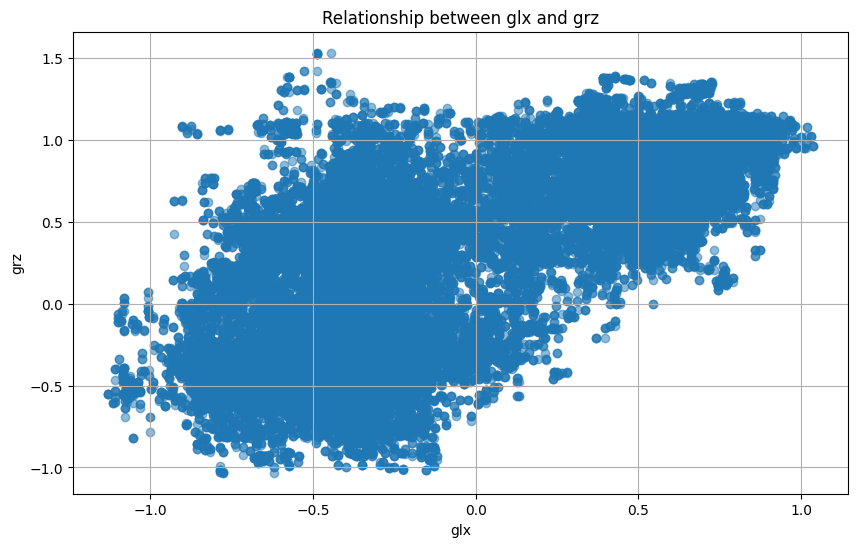

NaN values found in the dataset. Handling missing values...
NaN values found in the target variable after preprocessing. Please verify the preprocessing steps.


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Classification Model: KNN
Accuracy: 0.9932396542566034
Precision: 0.993437406141733
Recall: 0.9932396542566034
F1 Score: 0.9932397974500016
Confusion Matrix: [[14478     0     0     0    27     0     0     0     0     0     1]
 [    0   630     0     0     0     0     0     0     0     0     0]
 [    0     0   609     0     0     0     0     0     0     0     0]
 [    0     0     0   634     0     0     0     0     0     0     0]
 [    2     0     0     0   631     0     0     0     0     0     0]
 [    0     0     0     0     0   612     0     0     0     0     0]
 [    0     0     0     0     0     0   633     2     0     0     0]
 [    0     0     0     0     0     0     5   650     0     0     0]
 [    0     0     0     0     0     0     0     0   618     0     0]
 [    2     0     0     0     1     0     0     0     0   562    25]
 [    1     0     0     0     0     0     0     0     0    74   512]]


Classification Model: SVM
Accuracy: 0.9999517118161186
Precision: 0.999951787740

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error
from sklearn.impute import SimpleImputer

def preprocess_data(data):
    data_numeric = data.apply(pd.to_numeric, errors='coerce')

    if data_numeric.isnull().values.any():
        print("NaN values found in the dataset. Handling missing values...")
        imputer = SimpleImputer(strategy='mean')
        data_imputed = imputer.fit_transform(data_numeric)
        X = data_imputed
        y = data['Activity']
    else:
        X = data_numeric.drop(columns=['Activity', 'subject'])
        y = data_numeric['Activity']

    if y.isnull().values.any():
        print("NaN values found in the target variable after preprocessing. Please verify the preprocessing steps.")

    return X, y


def preprocess_subset(X, y, subset_size):
    data = pd.concat([pd.DataFrame(X), pd.DataFrame(y, columns=['Activity'])], axis=1)
    data.dropna(inplace=True)
    data.drop_duplicates(inplace=True)
    X = data.drop(columns=['Activity'])
    y = data['Activity']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    np.random.seed(42)
    subset_indices = np.random.choice(X_train_full.shape[0], subset_size, replace=False)
    X_train = X_train_full[subset_indices]
    y_train = y_train_full.iloc[subset_indices]

    return X_train, X_test, y_train, y_test


data = pd.read_csv("mhealth_raw_data.csv")

sample_data = data.sample(n=10000)
plt.figure(figsize=(10, 6))
plt.scatter(data['glx'], data['grz'], alpha=0.5)
plt.xlabel('glx')
plt.ylabel('grz')
plt.title('Relationship between glx and grz')
plt.grid(True)
plt.show()


X, y = preprocess_data(data)

subset_size = 10000
X_train_scaled, X_test_scaled, y_train, y_test = preprocess_subset(X, y, subset_size)

models = {
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Neural Network": MLPClassifier(max_iter=1000),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

param_distributions = {
    'KNN': {'n_neighbors': [3, 5, 7]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Neural Network': {'hidden_layer_sizes': [(50,), (100,), (150,)]},
    'Logistic Regression': {'C': [0.1, 1, 10]}
}

for name, model in models.items():
    if name in param_distributions:
        random_search = RandomizedSearchCV(model, param_distributions[name], cv=5, n_iter=5, n_jobs=-1)
        random_search.fit(X_train_scaled, y_train)
        models[name] = random_search.best_estimator_

cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    cv_scores[name] = scores.mean()

evaluation_metrics = {}
for name, model in models.items():
    if name != "Linear Regression":
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        confusion = confusion_matrix(y_test, y_pred)
        evaluation_metrics[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Confusion Matrix': confusion}

for name, metrics in evaluation_metrics.items():
    print(f"Classification Model: {name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("\n")

print("Cross-validation scores for classification models:")
for name, score in cv_scores.items():
    print(f"{name}: {score}")
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)
y_pred_lr = linear_reg.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print(f"Linear Regression Mean Squared Error (MSE): {mse_lr}")
print(f"Linear Regression Root Mean Squared Error (RMSE): {rmse_lr}")

# results
# 1 Interpretation of Model Predictions:
# all of them showed a good high accuracy and precision and recall and F1 scores
# these shows a graet results regarding classfication activities on the MHEALTH dataset
# we knew the accuarcy of the classfication of different activities based on the confusion matrix
# linear regression : it shows a good fit to the data because its low value of MSE and RMSE
# 2 Identification of the Best-Performing Model:
# the SVM model achieved the best scores across different metrics , showing that it is the best model for that dataset
# The other models performed well too but not like the SVM , it was slightly better
# 3.Strengths and Weaknesses of Each Model:
# KNN : its strength lyes on its simplicity and with working with non linear data ,making it a good choce in this area
# its weaknesses that it is not good in working with redundant features and cannot work with large datasets effectively
# SVM : its strength lyes in findng the best hyperplane this will result in a higher accuracy , but its weaknesses is that it need a huge time and a huge computaion powers foe working with large datasets
# Neural Network :its strength lyes in making and recognizing different complex patterns , and its weaknesses that it need a huge amount of data
# Logistic regression :  its strength lyes in its simplicity and its efficiency but its weaknesses tht it overfits with high dimensional data
# 4.Insights into Factors Contributing to Performance Variation:
# The performance depends on different things like the design of each model and its complexity , and data shape and its features , the responding of each one according to the outliers , the performance of each model with diifernt linearity models whether it is a linear or nonlinear
# the  effective of ach one depends on the distributaion of the data and its level of complexity
# The svm model acted really well because its ability to play in handy in suitations like a high dimensional data and find the best hyperplanes

# Conclusion
# the conclusion that the svm is the best model acting here on the activity recognition in the MHEALTH dataset. resulting in the best metrics
# so svm had the highest dataset and preciosn and recall and f1 scores , this enabeled it to be the most suitable one in the actvity recognation on that dataset



